### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1)
$\frac{dL(a(x_i), y_i)}{da(x_i)} = -2(y_i - a(x_i))$

2)
$\frac{dL(a(x_i), y_i)}{da(x_i)} = -exp( -a(x_i) y_i) *y_i$

3)
$\frac{dL(a(x_i), y_i)}{da(x_i)} = \frac{-y_i*exp(-a(x_i)*y_i)}{(1+exp(-a(x_i)y_i)*ln(a)}$
,a - основание логарифма

Таргет соотвественно тоже самое с минусом

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [599]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from numpy.random import permutation

In [794]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, loss="MSE", learning_rate=0.05, n_estimators=100, colsample=0.9,
                 subsample=0.9, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.model_init = None
        
    def cooltarget(self, a, y):
        if self.loss=='MSE':
            return -2 * (a - y)
        elif self.loss == 'EXP':
            return np.exp(-y * a) * y
        elif self.loss == "LOG":
            return y * np.exp(-a * y) / (1 + np.exp(-a * y))
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        self.y = np.asarray(y)
        if init_model is None:
            F = 0.5 * np.ones([y.shape[0]])
            save = F
        else:
            model_init = init_model()
            model_init.fit(X, y)
            F = model_init.predict(X)
            self.model_init = model_init
        predictions = []
        self.predicter = []
        self.feat = []
        k_col = int(np.round(X.shape[1] * self.colsample))
        k_sub = int(np.round(X.shape[0] * self.subsample))
        for i in range(self.n_estimators):
            sub_samp_ind = permutation(k_sub)
            col_samp_ind = permutation(k_col)
            self.feat.append(col_samp_ind)
            X_sample = X[sub_samp_ind]
            X_sample = X_sample[:, col_samp_ind]
            model = base_model(*self.args, **self.kwargs)
            target = self.cooltarget(F[sub_samp_ind], y[sub_samp_ind])
            model.fit(X_sample, target)
            self.predicter.append(model)
            F += self.learning_rate * model.predict(X[:, col_samp_ind])
        
    def predict(self, X):
        if self.model_init is None:
            F = np.ones(X.shape[0]) * 0.5
        else:
            F = self.model_init.predict(X)
        for k, predicter in enumerate(self.predicter):
            F += self.learning_rate * predicter.predict(X[:, self.feat[k]])
        return np.round(F)


In [795]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [796]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [797]:
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [724]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [725]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [730]:
from tqdm import tqdm

In [733]:
my_clf = MyGradientBoostingClassifier()
accuracy = []
for n_est in tqdm(range(1, 80)):
    my_clf = MyGradientBoostingClassifier(n_estimators=n_est)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 79/79 [05:50<00:00,  4.43s/it]


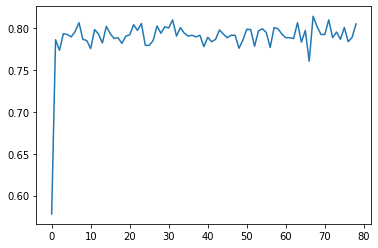

In [735]:
import matplotlib.pyplot as plt
plt.plot(accuracy)

In [763]:
accuracy = []
params = []
from sklearn.model_selection import cross_val_score
for loss in ["MSE", "LOG", "EXP"]:
    for lr in tqdm(np.arange(0.05, 0.16, 0.05)):
        for sub in [0.3, 0.7, 0.9]:
            for col in [0.3, 0.7, 0.9]:
                my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=lr
                                                      , n_estimators=20, colsample=col,
                                                         subsample=sub)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
                my_clf.fit(X_train, y_train)
                accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
                params.append((loss, lr, sub, col))

100%|██████████| 3/3 [00:29<00:00,  9.94s/it]


In [764]:
params[np.argmax(accuracy)]

('MSE', 0.05, 0.9, 0.9)

In [772]:
accuracy = []
params = []
from sklearn.model_selection import cross_val_score
for n in range(10, 50, 10):
    my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=n, colsample=0.9,
                                             subsample=0.9)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    params.append(n)

In [773]:
params[np.argmax(accuracy)]

20

In [774]:
np.max(accuracy)

0.7969961240310077

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [776]:
from sklearn.ensemble import RandomForestRegressor

In [778]:
my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=20, colsample=0.9,
                                             subsample=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8488372093023255

In [779]:
from numpy.random import randint

In [792]:
a = np.zeros(X_test.shape[0])
for i in range(20):
    index = randint(0, X_test.shape[0], size=X_train.shape[0])
    X_train_1 = X_train[index]
    y_train_1 = y_train[index]
    my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=20, colsample=0.9,
                                             subsample=0.9)
    my_clf.fit(X_train_1, y_train_1)
    a += my_clf.predict(X_test)
a = np.round(a / 20)
accuracy_score(y_pred=a, y_true=y_test)

0.813468992248062

Наблюдается улучшение в обоих случаях. Потому что если бы не улучшалось, то не делали бы.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [798]:
from sklearn.linear_model import LinearRegression

In [799]:
my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=20, colsample=0.9,
                                             subsample=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train, init_model=LinearRegression)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7873062015503876

In [800]:
my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=20, colsample=0.9,
                                             subsample=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.874031007751938

In [806]:
from sklearn.svm import SVR

In [807]:
my_clf = MyGradientBoostingClassifier(loss="MSE", learning_rate=0.05
                                          , n_estimators=20, colsample=0.9,
                                             subsample=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train, init_model=SVR)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7940891472868217

RandomForest помог улучшить качество, остальные нет. Потому что подобрал более подходящие начальные константы:)

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

